Other Ideas:
- Check whether images that are both in the test dataset are symetrically ranked highly
- Remove -1 images
- For ties in euclidean distance, select image that has a smaller time difference to reference image
- Use all data, also from kaggle
- Use ensemble 
- Use 2. place winner solution


In [225]:
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
import cv2


In [226]:
model_name = 'seresnext101'
fold = 2
checkpoint = '20600'
algo = 'dist_global_org'

In [227]:
df = pd.read_csv(f'WC_result/{model_name}_{fold}/out_{checkpoint}/postprocessing_{model_name}_sub_fold{fold}_{algo}.csv', header=None)

In [39]:
test_imgs = glob('WC_input/test/**.jpg')

test_imgs = [Path(img).name for img in test_imgs ]

test_imgs  = pd.DataFrame(test_imgs)

test_imgs['Id'] =  test_imgs[0].str.rsplit('-', 1).map(lambda x: x[1].split('.')[0])


test_imgs['date'] = test_imgs[0].str.rsplit('-', 1).map(lambda x: x[0].rsplit('-')[2])


In [53]:
test_imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       808 non-null    object
 1   Id      808 non-null    object
 2   date    808 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [55]:
test_imgs['img_id'] = test_imgs['date'] + test_imgs['Id']

In [72]:
import re
x = 'aas30dsa20'

In [73]:
re.sub('\D', '', x)

'3020'

In [76]:
test_imgs['img_id'] = test_imgs['img_id'].map(lambda x: re.sub('\D', '', x))

test_imgs[test_imgs['img_id'].map(lambda x: 'A' in  x)]

test_imgs['img_id'] = test_imgs['img_id'].astype(int)

test_imgs_minusone = test_imgs['img_id']-1

test_imgs_plusone =  test_imgs['img_id']+1

imgs_id_matched = test_imgs.merge(test_imgs_minusone, how='inner', on='img_id')

imgs_id_matched['img_id_org'] = imgs_id_matched['img_id'] +1

imgs_id_matched = imgs_id_matched.merge(test_imgs, left_on='img_id_org', right_on='img_id')



In [116]:
rows

('0_x', 0     PM-WWA-20170625-078.jpg
 1     PM-WWA-20180329-023.jpg
 2     PM-WWA-20180522-163.jpg
 3     PM-WWA-20170710-015.jpg
 4     PM-WWA-20170819-261.jpg
 5     PM-WWA-20170417-075.jpg
 6     PM-WWA-20180913-370.jpg
 7     PM-WWA-20180914-032.jpg
 8     PM-WWA-20170917-003.jpg
 9     PM-WWA-20180813-042.jpg
 10    PM-WWA-20180714-009.jpg
 11    PM-WWA-20180407-426.jpg
 12    PM-WWA-20180812-077.jpg
 13    PM-WWA-20170624-806.jpg
 14    PM-WWA-20180407-372.jpg
 15    PM-WWA-20180805-022.jpg
 16    PM-WWA-20180820-077.jpg
 17    PM-WWA-20170921-335.jpg
 18    PM-WWA-20180509-210.jpg
 Name: 0_x, dtype: object)

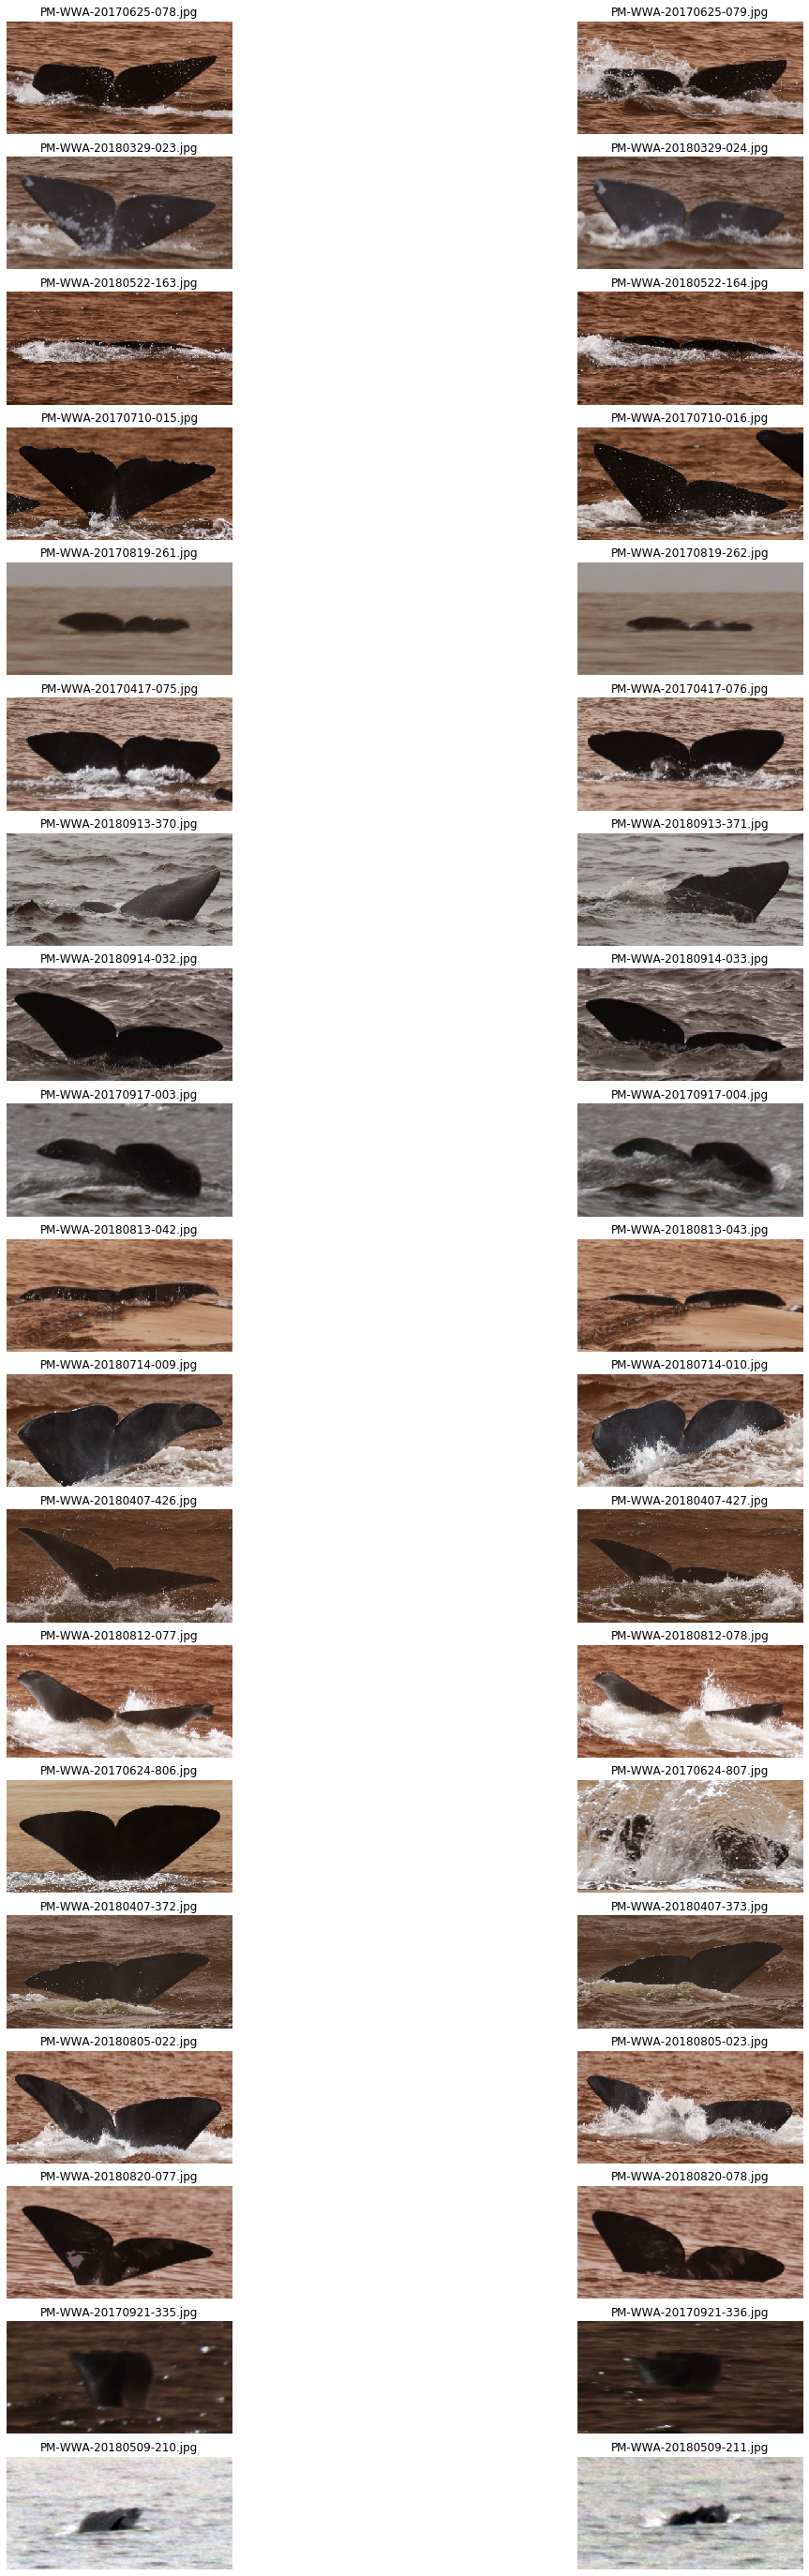

In [162]:
from matplotlib.pyplot import figure

f, axarr = plt.subplots(imgs_id_matched.shape[0], 2)
f.set_figwidth(20)
f.set_figheight(50)

for i in range(imgs_id_matched.shape[0]):
    
    # fetch the url as a file type object, then read the image
    f1 = imgs_id_matched.loc[i, '0_x']
    f2 = imgs_id_matched.loc[i, '0_y']
    
    a =  cv2.imread('WC_input/test/'+f1)
    b =  cv2.imread('WC_input/test/'+f2)
    a = cv2.resize(a, (384, 192))
    b = cv2.resize(b, (384, 192))
    
    axarr[i,0].imshow(a)
    axarr[i,1].imshow(b)
    
    axarr[i,0].axis('off')
    axarr[i,1].axis('off')
    axarr[i,0].set_title(f1)
    axarr[i,1].set_title(f2)

In [165]:
a = imgs_id_matched[['0_x', '0_y']]

b = imgs_id_matched[['0_y', '0_x']]

a.columns = ['x', 'y']
b.columns = ['x', 'y']

a.drop(3).append(b.drop(3)).reset_index(drop=True).to_csv('nearest_neighbors/id_matched_imgs.csv', index=False)

pairs = a.drop(3).append(b.drop(3)).reset_index(drop=True)

dic_pairs = dict(zip(pairs.x, pairs.y))

In [222]:
len(dic_pairs)

36

In [283]:
len(set(df[df[0]=='PM-WWA-20180509-210.jpg'].loc[797].tolist()))

21

In [272]:
dic_pairs['PM-WWA-20180509-210.jpg']

'PM-WWA-20180509-211.jpg'

In [284]:
inject_matched_img(df.iloc[797])

PM-WWA-20180509-210.jpg


0        PM-WWA-20180509-210.jpg
1        PM-WWA-20180509-211.jpg
2     PM-WWA-20090718-Hay009.jpg
3        PM-WWA-20120520-009.jpg
4        PM-WWA-20100813-025.jpg
5        PM-WWA-20150810-676.jpg
6        PM-WWA-20110630-058.jpg
7        PM-WWA-20080713-009.jpg
8        PM-WWA-20150414-243.jpg
9        PM-WWA-20100727-039.jpg
10       PM-WWA-20130630-108.jpg
11       PM-WWA-20070419-105.jpg
12       PM-WWA-20090811-192.jpg
13       PM-WWA-20060911-050.jpg
14       PM-WWA-20150810-699.jpg
15       PM-WWA-20060610-130.jpg
16       PM-WWA-20150409-378.jpg
17       PM-WWA-20050723-109.jpg
18       PM-WWA-20150601-475.jpg
19       PM-WWA-20080719-094.jpg
20       PM-WWA-20050623-066.jpg
dtype: object

In [270]:
def inject_matched_img(row):
    ref = row[0]
    s = row[1:].copy()
    if ref in dic_pairs.keys():
        imgs_same_class = dic_pairs[ref]
        s_list = s.tolist()
        if imgs_same_class in s_list:
            s_list.remove(imgs_same_class)
        result = [row[0]] + [imgs_same_class] + s_list
        result = pd.Series(result)
        print (ref)
    else:
#         print (ref)
        result = row
    return result[:21]

In [289]:
collector_df = []
for i in range(df.shape[0]):
    row = df.iloc[i]
    print (row[0])
    collector_df.append(inject_matched_img(row))

PM-WWA-20180811-093.jpg
PM-WWA-20170710-031.jpg
PM-WWA-20170622-226.jpg
PM-WWA-20180813-271.jpg
PM-WWA-20180506-348.jpg
PM-WWA-20170417-174.jpg
PM-WWA-20170528-041.jpg
PM-WWA-20170731-007.jpg
PM-WWA-20180506-365.jpg
PM-WWA-20170528-221.jpg
PM-WWA-20170819-391.jpg
PM-WWA-20180918-475.jpg
PM-WWA-20180710-236.jpg
PM-WWA-20170722-189.jpg
PM-WWA-20180801-070.jpg
PM-WWA-20170510-801.jpg
PM-WWA-20180807-403.jpg
PM-WWA-20180518-018.jpg
PM-WWA-20171101-053.jpg
PM-WWA-20170714-485.jpg
PM-WWA-20170414-424.jpg
PM-WWA-20170818-282.jpg
PM-WWA-20180522-176.jpg
PM-WWA-20170815-030.jpg
PM-WWA-20170713-012.jpg
PM-WWA-20180827-097.jpg
PM-WWA-20180717-318.jpg
PM-WWA-20170917-095.jpg
PM-WWA-20170417-112.jpg
PM-WWA-20170623-740.jpg
PM-WWA-20180713-079.jpg
PM-WWA-20180722-103.jpg
PM-WWA-20180626-064.jpg
PM-WWA-20170627-071.jpg
PM-WWA-20170811-048.jpg
PM-WWA-20180802-015.jpg
PM-WWA-20170728-010.jpg
PM-WWA-20170724-077.jpg
PM-WWA-20170625-078.jpg
PM-WWA-20170625-078.jpg
PM-WWA-20180803-018.jpg
PM-WWA-20170321-

PM-WWA-20170607-069.jpg
PM-WWA-20180522-056.jpg
PM-WWA-20180712-013.jpg
PM-WWA-20170710-962.jpg
PM-WWA-20180731-510.jpg
PM-WWA-20180613-061.jpg
PM-WWA-20170707-594.jpg
PM-WWA-20170625-452.jpg
PM-WWA-20170430-020.jpg
PM-WWA-20180801-093.jpg
PM-WWA-20180610-143.jpg
PM-WWA-20180911-083.jpg
PM-WWA-20180703-011.jpg
PM-WWA-20180701-139.jpg
PM-WWA-20170528-207.jpg
PM-WWA-20180827-112.jpg
PM-WWA-20180807-034.jpg
PM-WWA-20180806-023.jpg
PM-WWA-20180725-013.jpg
PM-WWA-20180914-087.jpg
PM-WWA-20180814-455.jpg
PM-WWA-20170706-667.jpg
PM-WWA-20170710-111.jpg
PM-WWA-20170624-958.jpg
PM-WWA-20180614-600.jpg
PM-WWA-20180708-306.jpg
PM-WWA-20180606-066.jpg
PM-WWA-20170710-949.jpg
PM-WWA-20170725-053.jpg
PM-WWA-20170712-576.jpg
PM-WWA-20170625-079.jpg
PM-WWA-20170625-079.jpg
PM-WWA-20170812-547.jpg
PM-WWA-20170628-068.jpg
PM-WWA-20180612-038.jpg
PM-WWA-20170511-680.jpg
PM-WWA-20180810-243.jpg
PM-WWA-20170923-049.jpg
PM-WWA-20180813-016.jpg
PM-WWA-20180407-426.jpg
PM-WWA-20180407-426.jpg
PM-WWA-20180714-

In [294]:
result = pd.concat(collector_df, axis=1)

In [295]:
# df['new'] = df.apply(lambda x: inject_matched_img(x), axis=1)

In [296]:
# result = df['new'].apply(pd.Series)

In [300]:
result = result.T

In [305]:
result = result.set_index(0)

In [203]:
# result = result.set_index(0)

In [306]:
pairs

x                        y
0   PM-WWA-20170625-078.jpg  PM-WWA-20170625-079.jpg
1   PM-WWA-20180329-023.jpg  PM-WWA-20180329-024.jpg
2   PM-WWA-20180522-163.jpg  PM-WWA-20180522-164.jpg
3   PM-WWA-20170819-261.jpg  PM-WWA-20170819-262.jpg
4   PM-WWA-20170417-075.jpg  PM-WWA-20170417-076.jpg
5   PM-WWA-20180913-370.jpg  PM-WWA-20180913-371.jpg
6   PM-WWA-20180914-032.jpg  PM-WWA-20180914-033.jpg
7   PM-WWA-20170917-003.jpg  PM-WWA-20170917-004.jpg
8   PM-WWA-20180813-042.jpg  PM-WWA-20180813-043.jpg
9   PM-WWA-20180714-009.jpg  PM-WWA-20180714-010.jpg
10  PM-WWA-20180407-426.jpg  PM-WWA-20180407-427.jpg
11  PM-WWA-20180812-077.jpg  PM-WWA-20180812-078.jpg
12  PM-WWA-20170624-806.jpg  PM-WWA-20170624-807.jpg
13  PM-WWA-20180407-372.jpg  PM-WWA-20180407-373.jpg
14  PM-WWA-20180805-022.jpg  PM-WWA-20180805-023.jpg
15  PM-WWA-20180820-077.jpg  PM-WWA-20180820-078.jpg
16  PM-WWA-20170921-335.jpg  PM-WWA-20170921-336.jpg
17  PM-WWA-20180509-210.jpg  PM-WWA-20180509-211.jpg
18  PM-WWA-20170625-079.jpg  PM-WWA-20170625-078.jpg
19  PM-WWA-20180329-024.jpg  PM-WWA-20180329-023.jpg
20  PM-WWA-20180522-164.jpg  PM-WWA-20180522-163.jpg
21  PM-WWA-20170819-262.jpg  PM-WWA-20170819-261.jpg
22  PM-WWA-20170417-076.jpg  PM-WWA-20170417-075.jpg
23  PM-WWA-20180913-371.jpg  PM-WWA-20180913-370.jpg
24  PM-WWA-20180914-033.jpg  PM-WWA-20180914-032.jpg
25  PM-WWA-20170917-004.jpg  PM-WWA-20170917-003.jpg
26  PM-WWA-20180813-043.jpg  PM-WWA-20180813-042.jpg
27  PM-WWA-20180714-010.jpg  PM-WWA-20180714-009.jpg
28  PM-WWA-20180407-427.jpg  PM-WWA-20180407-426.jpg
29  PM-WWA-20180812-078.jpg  PM-WWA-20180812-077.jpg
30  PM-WWA-20170624-807.jpg  PM-WWA-20170624-806.jpg
31  PM-WWA-20180407-373.jpg  PM-WWA-20180407-372.jpg
32  PM-WWA-20180805-023.jpg  PM-WWA-20180805-022.jpg
33  PM-WWA-20180820-078.jpg  PM-WWA-20180820-077.jpg
34  PM-WWA-20170921-336.jpg  PM-WWA-20170921-335.jpg
35  PM-WWA-20180509-211.jpg  PM-WWA-20180509-210.jpg

In [312]:
result.to_csv(f'WC_result/{model_name}_{fold}/out_{checkpoint}/postprocessingII_{model_name}_sub_fold{fold}_{algo}.csv',
                                  header=None, index=True)

In [307]:
result.loc['PM-WWA-20170625-078.jpg']

1      PM-WWA-20170625-079.jpg
2      PM-WWA-20180622-392.jpg
3      PM-WWA-20070703-112.jpg
4      PM-WWA-20090522-052.jpg
5      PM-WWA-20070628-153.jpg
6      PM-WWA-20070808-014.jpg
7      PM-WWA-20070710-241.jpg
8      PM-WWA-20160429-369.jpg
9      PM-WWA-20160429-347.jpg
10     PM-WWA-20110921-033.jpg
11     PM-WWA-20060622-052.jpg
12     PM-WWA-20080710-016.jpg
13     PM-WWA-20060622-054.jpg
14     PM-WWA-20090705-124.jpg
15     PM-WWA-20070831-024.jpg
16     PM-WWA-20060621-007.jpg
17     PM-WWA-20050707-159.jpg
18    PM-WWA-20060621-A017.jpg
19     PM-WWA-20110731-144.jpg
20     PM-WWA-20100723-511.jpg
Name: PM-WWA-20170625-078.jpg, dtype: object

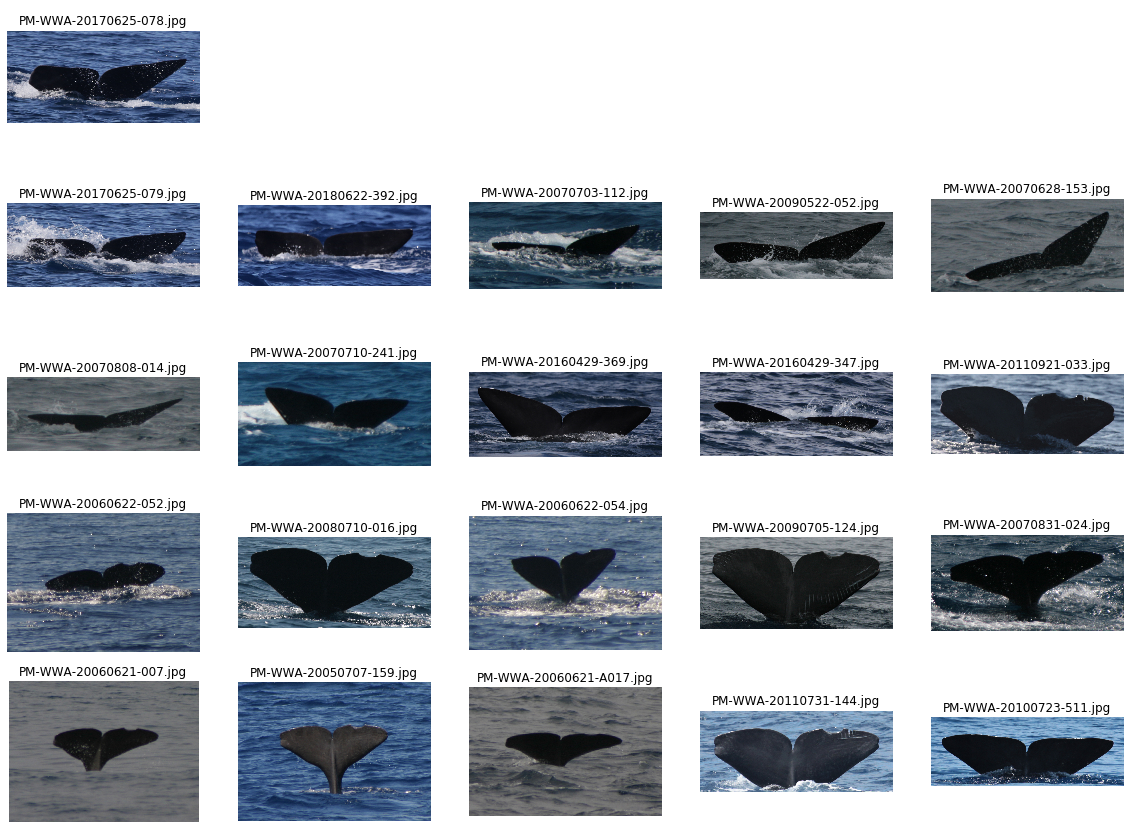

In [337]:
img_ref_name = 'PM-WWA-20170625-078.jpg'

f, axarr = plt.subplots(5, 5)
f.set_figwidth(20)
f.set_figheight(15)

for i in range(0, 20):
    img_name = result.loc[img_ref_name, i+1]
    img =  plt.imread('./WC_input/data/'+img_name)
    
    axarr[int(i/5)+1, i%5].imshow(img)
    axarr[int(i/5)+1, i%5].axis('off')
    axarr[int(i/5)+1, i%5].set_title(img_name)
    
img = plt.imread('./WC_input/data/'+img_ref_name)
axarr[0, 0].imshow(img)
axarr[0, 0].axis('off')
axarr[0, 0].set_title(img_ref_name)
axarr[0, 1].axis('off')
axarr[0, 2].axis('off')
axarr[0, 3].axis('off')
axarr[0, 4].axis('off')

plt.show()